In [302]:
from __future__ import print_function
import geopandas as gpd
import pandas as pd
import numpy as np
import urllib
import requests
import os
import io
import json
import pylab as pl
import shapely
import shapely.wkt
from fiona.crs import from_epsg
import sys
import choropleth as cp

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shape', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [303]:
# environment variable

os.environ["PUIDATA"] = "%s/PUIDATA"%os.getenv("HOME")
print("PUIDATA", os.getenv("PUIDATA"))

PUIDATA /nfshome/cb4221/PUIDATA


In [304]:
# downloading a zipped file

url='https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'
urllib.request.urlretrieve(url, "file.gz")
# unpacking into $PUIDATA
!unzip file.gz -d $PUIDATA

Archive:  file.gz
  inflating: /nfshome/cb4221/PUIDATA/geo_export_33783d35-27fd-4f06-b893-748aa5c3a2d4.dbf  
  inflating: /nfshome/cb4221/PUIDATA/geo_export_33783d35-27fd-4f06-b893-748aa5c3a2d4.shp  
  inflating: /nfshome/cb4221/PUIDATA/geo_export_33783d35-27fd-4f06-b893-748aa5c3a2d4.shx  
  inflating: /nfshome/cb4221/PUIDATA/geo_export_33783d35-27fd-4f06-b893-748aa5c3a2d4.prj  


**TASK 1 - Working with PUMA**

In [305]:
# reading in data with geopandas - file name is taken directly from above

pdf = gpd.GeoDataFrame.from_file("%s/geo_export_319632ad-e616-4961-8e3d-a095abd63876.shp"%os.getenv("PUIDATA"))

In [306]:
# rearranging columns
pdf2 = pdf[['puma', 'shape_leng', 'shape_area', 'geometry']]
pdf2.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144461,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.002302,1.889860e+08,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,304071.257466,2.670137e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.901277,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,50007.415493,8.105438e+07,POLYGON ((-73.95374853778468 40.63858633758547...


In [307]:
pdf2.crs

{'init': 'epsg:4326'}

In [308]:
# need to convert lat/long to meters or feet - just how this works 
pdf2.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
shape = pdf2.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print ('total NYC land area: %s (mi^2)'%str(shape)[:5]) # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


**TASK 1.2 PLOTTING PUMA REGIONS**

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


Text(0.5,1,'Breakdown of NYC PUMAs')

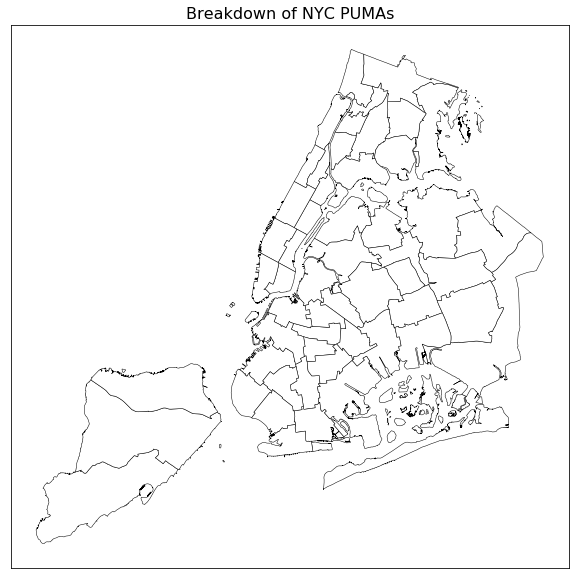

In [309]:
#plotting geodata
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pdf2.plot(column='puma',alpha=1,linewidth=0.5,ax=ax,color="white",edgecolor="black")
plt.title("Breakdown of NYC PUMAs", fontsize=16)

Figure 1: The map above shows the breakdown of PUMAs across the five NYC boroughs, as defined by the US Census Bureau. PUMAs contain approximately 100,000 people. 

In [310]:
# file name: census_api.py
%run census_api.py

In [311]:
#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [312]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))

In [313]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type')]

In [314]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [315]:
#keyword for the number of households with broadband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [316]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [317]:
#getting the first row of the table: the total number of households

keyNPP = 'B28002_001E'
aff1y['variables'][keyNPP]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [318]:
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNPP +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [319]:
#merge number of households w broadband access and total number of households
pumaBB = pumaBB.merge(pumaPP)
pumaBB2 = pumaBB.drop('Unnamed: 4', axis=1)
pumaBB2.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E
0,32607,"St. Lawrence County PUMA, New York",36,100,40479
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146


In [320]:
# setting up new feature with percentage of households with broadband access

pumaBB2['pcBB'] = pumaBB2.apply(lambda row: row.B28002_004E / row.B28002_001E * 100, axis=1)
pumaBB2.head()

,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


In [321]:
# comparing results with table
# first load in data using pandas
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.head()
#pd.read_csv(datafile, sep=';', comment='#', header=0, skiprows=[1])  

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8


In [322]:
bbpc.columns

Index(['GCT_STUB.target-geo-id2', 'HC01', 'HC02'], dtype='object')

In [323]:
# renaming columns because changing'GCT_STUB.target-geo-id2' causes error - need to rename to something else
bbpc.columns = ['GeoID', 'HC01', 'HC02'] 
# could also do this: bbpc.rename(columns={"GCT_STUB.target-geo-id2":"GeoID"}, inplace=True)
pd.to_numeric(bbpc.GeoID, errors='coerce')
bbpc.head()

,GeoID,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8


In [324]:
bbpc.drop(0, inplace=True)
bbpc.head()

,GeoID,HC01,HC02
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8
5,0100302,81.9,2.9


In [325]:
# checking column type of GeoID - needs to be int
bbpc.GeoID.dtype

dtype('O')

In [326]:
# converting column type to int
# sample code from stack: df.a = df.a.astype(float)
bbpc.GeoID = bbpc.GeoID.astype(int) #convert column type to int
bbpc.GeoID.dtype #checking that it works

dtype('int64')

In [327]:
# making df compatible with 4-digit PUMA codes above 
bbpc = bbpc[(bbpc.GeoID > 3600000) & (bbpc.GeoID < 5700000)]
bbpc["GeoID"] = bbpc.GeoID - 3600000
bbpc["HC01"] = bbpc["HC01"].astype(float)

In [328]:
# merging on PUMA code
diff_ = pumaBB2.merge(bbpc, right_on="GeoID", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,pcBB,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


**Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access**

In [329]:
# need to make sure columns you are merging are the same type
pumaBB2['public use microdata area'] = pumaBB2['public use microdata area'].astype(str)
pdf2['puma'] = pdf2['puma'].astype(str)

#choropleth of the percentage of internet axcess
pdf_2 = pdf2.merge(pumaBB2, left_on="puma", right_on="public use microdata area", how='left')
pdf_2.head() #getting an empty dataframe


,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,B28002_001E,pcBB
0,3701,53227.144461,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820
1,3702,106050.002302,1.889860e+08,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015
2,3703,304071.257466,2.670137e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141
3,3704,47970.901277,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737
4,4015,50007.415493,8.105438e+07,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,55953,78.778618


(<matplotlib.figure.Figure at 0x7f6fcc25c0f0>,
 <matplotlib.colorbar.Colorbar at 0x7f6fcb1f31d0>)

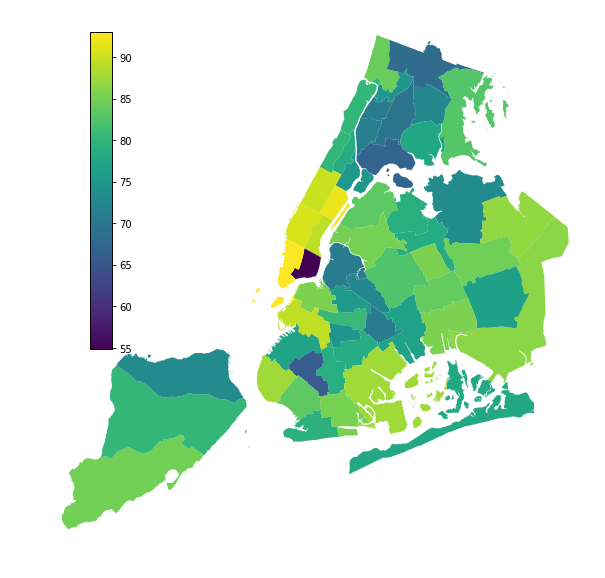

In [330]:
cp.choroplethNYC(pdf_2, column='pcBB', cmap='viridis', lw=2) 

Figure 2: Percentage of broadband access across NYC PUMAs. The most notable area of the map is the dark blue section on the lower east side of Manhattan, showing it has considerably less broadband access compared to the rest of Manhattan and NYC as a whole, despite being a very wealthy area. 

**LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed**

In [331]:
# go to link indicated, open file, click on raw, then copy url from browser
#file path = https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv
linkNYC = pd.read_csv("https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv", 
                   index_col=0)
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [332]:
linkNYC.shape

(1414, 4)

**Combine long lat into a column like you did in the lab to create a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame linkNYC and set native coordinates frame to lat/lon as you did in the lab**

In [333]:
# combine lat and lon from linkNYC to one column
linkNYC['lonlat']=list(zip(linkNYC.longitude,linkNYC.latitude))

# Create Point Geometry based on lonlat column
linkNYC['geometry']=linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

# these are our points

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [334]:
linkNYC = gpd.GeoDataFrame(linkNYC)
type(linkNYC)

geopandas.geodataframe.GeoDataFrame

In [335]:
# need to convert lat/long to meters or feet
#linkNYC.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
#linkNYC = linkNYC.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 

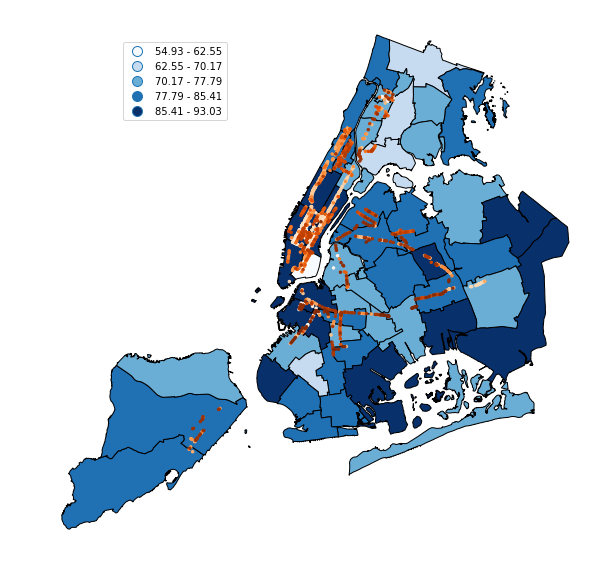

In [336]:
# choropleth above: 
#cp.choroplethNYC(pdf_2, column='', cmap='viridis', lw=2)

linkNYC.date_link_ = pd.to_datetime(linkNYC.date_link_) #converting date_link to data/time
ax = pl.figure(figsize=(10,10)).add_subplot(111)
cp.choroplethNYC(pdf_2, column="pcBB", scheme='equal_interval', k=5,
             cmap="Blues", ax=ax, edgecolor='black')
linkNYC.plot(ax=ax, marker='o', c="date_link_", 
             markersize=6, cmap="Oranges");

Figure 3: Location of LinkNYC stations and broadband access. Stations are heavily concentrated in Manhattan, which has exceptional broadband access. Sections of the upper Bronx and eastern and southern Queens are not adequately served by LinkNYC, since there are no stations in these areas and broadband access is relatively low. 

**Find the number of linkNYC locations per person by PUMA**

**5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF**

In [337]:
# the ACS population by variable is B00001_001E, and of course your geometry is PUMA, 
# public%20use%20microdata%20area:*, as before
keyNPP = 'B00001_001E'
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNPP +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPoP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))
pumaPoP.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [338]:
# need to make sure columns you are merging are the same type
pumaPoP['public use microdata area'] = pumaPoP['public use microdata area'].astype(str)
#pdf2['puma'] = pdf2['puma'].astype(str)

In [339]:
# merge with puma df pdf_2

pdf_2 = pdf2.merge(pumaPoP, left_on="puma", right_on="public use microdata area", how='left')
pdf_2.head() 

,puma,shape_leng,shape_area,geometry,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3701,53227.144461,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...,1517,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN
1,3702,106050.002302,1.889860e+08,"POLYGON ((-73.8442314689986 40.86942035096838,...",1959,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN
2,3703,304071.257466,2.670137e+08,(POLYGON ((-73.78833349834532 40.8346671297593...,1305,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN
3,3704,47970.901277,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,...",1882,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN
4,4015,50007.415493,8.105438e+07,POLYGON ((-73.95374853778468 40.63858633758547...,2515,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,NaN


In [340]:
type(pdf_2)

geopandas.geodataframe.GeoDataFrame

In [341]:
# convert coordinates for pumashp and linkNYC using method .to_crs

#pdf_2.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
#pdf_2=pdf_2.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 

In [342]:
#spatial join to "within"
linkpp = gpd.sjoin(linkNYC, pdf_2)[["puma", "link_site"]].groupby("puma").count()
linkpp.head()

,link_site
puma,
3701,1
3705,1
3706,20
3707,29
3708,19


In [343]:
# finally merge back into the pumashp
# merge outer so as to not to lose pumas
pumashplc = pdf_2.merge(linkpp, left_on="puma", right_index=True, how="outer")

In [344]:
#linkNYC per 100 inhabitants
pumashplc["linkNYCp100p"] = pumashplc["link_site"] / pumashplc["B00001_001E"] * 100

In [345]:
#linkNYC per 100 inhabitants
pumashplc["linkNYCp100p"].describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCp100p, dtype: float64

**Plot the linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals**

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


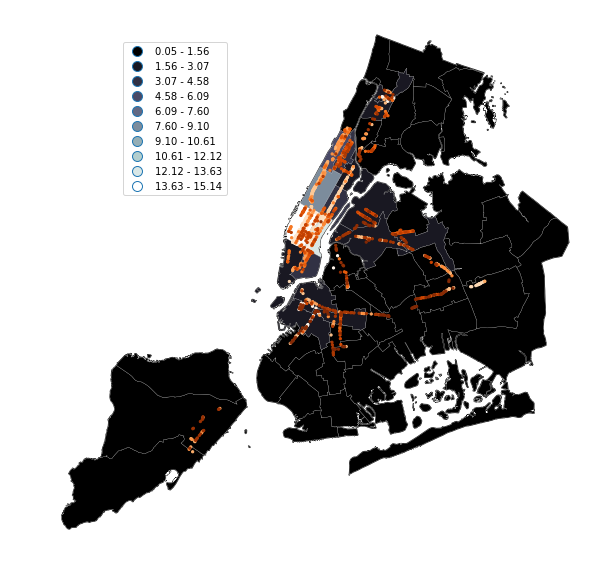

In [353]:
#plotting (plotting map underneath main choropleth cause i have NaNs
f, ax = cp.choroplethNYC(pdf_2, column=None, color="white", edgecolor="black")
f, ax, c = cp.choroplethNYC(pumashplc, column="linkNYCp100p", scheme='equal_interval', k=10,
                                    cmap="bone", ax=ax, edgecolor="white", lw=0.2)
linkNYC.plot(marker='o', c="date_link_", 
             markersize=5, cmap="Oranges", ax=ax);

Figure 4: LinkNYC locations on top of a choropleth of number of stations per 100 people.